In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl

In [2]:
base_consumos = pd.read_excel(r"C:/Users/JORGE CONTRERAS/ARCHIVO_INFORMES/CONSUMOS.xlsx")
base_items = pd.read_excel(r"C:/Users/JORGE CONTRERAS/ARCHIVO_INFORMES/ITEMS_INVENTARIO.xlsx")
base_inventarios = pd.read_excel(r"C:/Users/JORGE CONTRERAS/ARCHIVO_INFORMES/INVENTARIOS.xlsx")
base_OCC = pd.read_excel(r"C:/Users/JORGE CONTRERAS/ARCHIVO_INFORMES/OCC.xlsx")



Base OCC cargada correctamente.


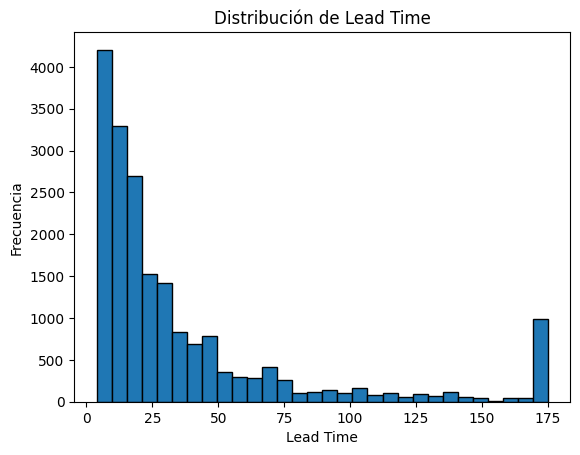

count    19397.000000
mean        37.020828
std         43.203737
min          4.000000
25%         11.000000
50%         21.000000
75%         42.000000
max        175.000000
Name: lead_time_winsorized, dtype: float64


c:\Users\JORGE CONTRERAS\metricas_almacen\tiempo_pedidos\tiempo_pedidos\Lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


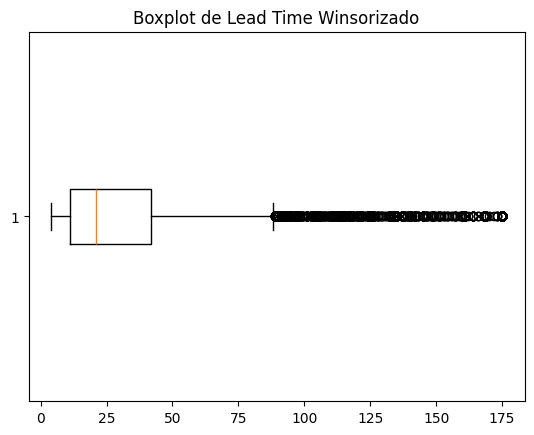

      Fecha aprobación solicitud          Fecha cumplido Fecha orden  \
0        2023-02-20 13:35:11.000 2023-03-01 16:28:43.000  2023-02-28   
1        2022-12-19 08:10:48.000 2023-06-06 13:54:16.000  2023-02-20   
2        2022-12-19 08:10:48.000 2023-06-06 13:54:16.000  2023-02-20   
3        2022-12-19 08:10:48.000 2023-06-06 13:54:16.000  2023-02-20   
4        2022-12-19 08:10:48.000 2023-06-06 13:54:16.000  2023-02-20   
...                          ...                     ...         ...   
19392    2023-10-27 11:12:09.887 2023-11-02 10:18:33.497  2023-10-30   
19393    2023-10-27 11:12:09.887 2023-11-10 07:38:21.770  2023-10-30   
19394    2024-01-11 12:20:16.960 2024-01-19 16:14:16.297  2024-01-12   
19395    2024-01-11 12:20:16.960 2024-02-07 15:51:51.503  2024-01-12   
19396    2024-01-03 08:16:10.007 2024-01-18 16:28:02.367  2024-01-11   

         Estado Bodega Referencia                                Desc. item  \
0      Cumplido  MP002    PZCH072                       

In [16]:
base_consumos_2023= base_consumos[base_consumos['Año']==2023]
base_consumos_2024= base_consumos[base_consumos['Año']==2024].copy()

mes_orden = {
    'ene': 1, 'feb': 2, 'mar': 3, 'abr': 4, 'may': 5,
    'jun': 6, 'jul': 7, 'ago': 8, 'sep': 9, 'oct': 10,
    'nov': 11, 'dic': 12
}

base_consumos_2024['Mes_orden'] = base_consumos_2024['Mes'].map(mes_orden)
base_consumos_2024 = base_consumos_2024.sort_values('Mes_orden').drop(columns='Mes_orden')



if 'base_OCC' not in globals():  # Solo carga si no está ya en memoria
    base_OCC = pd.read_excel(r"C:/Users/JORGE CONTRERAS/ARCHIVO_INFORMES/OCC.xlsx")

print("Base OCC cargada correctamente.")





base_OCC = base_OCC[base_OCC['Fecha aprobación solicitud'].notna() & base_OCC['Fecha cumplido'].notna() ]

base_OCC=base_OCC[['Fecha aprobación solicitud','Fecha cumplido','Fecha orden','Estado','Bodega','Referencia','Desc. item','U.M.','Cant. ordenada','Cant. entrada','Cant. pendiente']]


base_OCC['lead Time']=base_OCC['Fecha cumplido']-base_OCC['Fecha aprobación solicitud']

base_OCC
#base_OCC['Referencia']=base_OCC['Referencia'].str.strip()

import pandas as pd

# Calcular la media y desviación estándar por referencia
lead_time_stats = base_OCC.groupby('Referencia')['lead Time'].agg(['mean', 'std']).reset_index()

# Merge con la base original
base_OCC = base_OCC.merge(lead_time_stats, on='Referencia', how='left')

# Calcular Z-score normalizado
base_OCC['lead Time Normalizado'] = (base_OCC['lead Time'] - base_OCC['mean']) / base_OCC['std']

'''

# Calcular percentiles 5 y 95 por cada referencia (ítem)
percentiles = base_OCC.groupby("Referencia")["lead Time"].quantile([0.05, 0.95]).unstack()

# Función para ajustar valores atípicos por referencia
def ajustar_outliers(row):
    ref = row["Referencia"]
    lead_time = row["lead Time"]
    
    # Obtener percentiles de la referencia
    p5 = percentiles.loc[ref, 0.05] if ref in percentiles.index else lead_time
    p95 = percentiles.loc[ref, 0.95] if ref in percentiles.index else lead_time
    
    # Ajustar valores extremos
    if lead_time < p5:
        return p5
    elif lead_time > p95:
        return p95
    return lead_time

# Aplicar la corrección a la columna Lead Time
base_OCC["lead Time Ajustado"] = base_OCC.apply(ajustar_outliers, axis=1)

# Guardar el archivo corregido en Excel
base_OCC.to_excel("OCC_T_Ajustado.xlsx", index=False)

print("Archivo ajustado guardado como OCC_T_Ajustado.xlsx")


'''
from scipy.stats.mstats import winsorize
# Convertir Lead Time a número de días si está en formato timedelta
if pd.api.types.is_timedelta64_dtype(base_OCC["lead Time"]):
    base_OCC["lead Time"] = base_OCC["lead Time"].dt.days


lead_time_mean = base_OCC['lead Time'].mean()
standard_lead_time = base_OCC['lead Time'].std()

base_OCC['lead_time_z_score']= (base_OCC['lead Time']-lead_time_mean)/standard_lead_time

base_OCC['lead time log']= np.log(base_OCC['lead Time']+1)

lower_bound = base_OCC['lead Time'].quantile(0.05)
upper_bound = base_OCC['lead Time'].quantile(0.95)
base_OCC['lead_time_winsorized_T'] = base_OCC['lead Time'].clip(lower_bound, upper_bound)

lead_time_winsorixede = winsorize(base_OCC['lead Time'], limits=[0.05, 0.05])

base_OCC['lead_time_winsorized'] = lead_time_winsorixede



# Histograma de la columna "lead Time"
plt.hist(base_OCC['lead Time'].dropna(), bins=30, edgecolor='black')
plt.title("Distribución de Lead Time")
plt.xlabel("Lead Time")
plt.ylabel("Frecuencia")
plt.show()

# Resumen estadístico de la columna Winsorizada
print(base_OCC['lead_time_winsorized'].describe())

# Gráfico de caja de la columna Winsorizada
plt.boxplot(base_OCC['lead_time_winsorized'].dropna(), vert=False)
plt.title("Boxplot de Lead Time Winsorizado")
plt.show()
# Ver los resultados
print(base_OCC)


base_OCC.to_excel(r"C:/Users/JORGE CONTRERAS/ARCHIVO_INFORMES/OCC_T.xlsx", sheet_name='CONSUMOS_2025', index=False)


In [224]:
lead_time_nacional = 0.32
lead_time_internacional = 4.8
lead_time_internacional_francia = 3.6


base_final_2024_MAX=base_consumos_2024.groupby(['Referencia','Desc. item','Bodega'])['Salidas (inv.)'].max().reset_index()
base_final_2024_MEAN=base_consumos_2024.groupby(['Referencia','Desc. item','Bodega'])['Salidas (inv.)'].mean().reset_index()

base_final_demanda_pro_max=base_final_2024_MAX.merge(base_final_2024_MEAN, on=['Referencia','Desc. item','Bodega'], how='left')

base_final_2024=base_consumos_2024.groupby(['Referencia','Desc. item','Bodega']).agg(
    consumo_total = ('Salidas (inv.)','sum')
    
).reset_index()  #consumos totales por mes TABLA

base_final_2024_agrupada = base_final_2024.groupby(['Referencia','Desc. item','Bodega'])['consumo_total'].sum().reset_index()






In [225]:
# Renombrar las columnas para evitar conflictos
base_final_2024_agrupada = base_final_2024_agrupada.rename(columns={'consumo_total': 'consumo_total_2024'})
#base_final_2024_agrupada_minimo = base_final_2024_agrupada_minimo.rename(columns={'consumo_total': 'consumo_minimo'})
#base_final_2024_agrupada_maximo = base_final_2024_agrupada_maximo.rename(columns={'consumo_total': 'consumo_maximo'})
#base_final_2024_agrupada_promedio = base_final_2024_agrupada_promedio.rename(columns={'consumo_total': 'consumo_promedio'})
#base_final_2024_agrupada_standar = base_final_2024_agrupada_standar.rename(columns={'consumo_total': 'consumo_standar'})

# Realizar los merges una sola vez por DataFrame
base_items = base_items.merge(base_final_2024_agrupada, on=['Referencia', 'Desc. item', 'Bodega'], how='left')
#base_items = base_items.merge(base_final_2024_agrupada_minimo, on=['Referencia', 'Desc. item', 'Bodega'], how='left')
#base_items = base_items.merge(base_final_2024_agrupada_maximo, on=['Referencia', 'Desc. item', 'Bodega'], how='left')
#base_items = base_items.merge(base_final_2024_agrupada_standar, on=['Referencia', 'Desc. item', 'Bodega'], how='left')
#base_items = base_items.merge(base_final_2024_agrupada_promedio, on=['Referencia', 'Desc. item', 'Bodega'], how='left')

base_items['consumo_diario'] = base_items['consumo_total_2024'] / 300

dias_operacion = 25

base_OCC_max=base_OCC.groupby(['Referencia','Desc. item','U.M.','Bodega'])['lead Time'].max().reset_index()


base_OCC_mean=base_OCC.groupby(['Referencia','Desc. item','U.M.','Bodega'])['lead Time'].mean().reset_index()

base_OCC_lead_time=base_OCC_max.merge(base_OCC_mean, on=['Referencia','Desc. item','U.M.','Bodega'], how='left')

base_OCC_lead_time = base_OCC_lead_time[base_OCC_lead_time['Bodega'].isin(['MP002', 'MP001'])]

base_OCC_lead_time = base_OCC_lead_time.rename(columns={'lead Time_x': 'Max lead time', 'lead Time_y': 'Mean lead time'}) # tabla de

#base_OCC_lead_time=base_OCC.copy()

base_OCC_lead_time.to_excel(r"C:/Users/JORGE CONTRERAS/ARCHIVO_INFORMES/OCC _T.xlsx", sheet_name='CONSUMOS_2025', index=False)


base_items=base_items.merge(base_final_demanda_pro_max, on=['Referencia', 'Desc. item', 'Bodega'], how='left')

base_items = base_items.rename(columns={'Salidas (inv.)_x': 'Demand Max ', 'Salidas (inv.)_y': 'Demand Mean'})

base_OCC_lead_time_V2 = base_OCC_lead_time.merge(base_items, on=['Referencia', 'Desc. item', 'Bodega'], how='left')


'''
base_items['stock_seguridad'] = (1.65)*(base_items['consumo_standar'])*(np.where(
    base_items['STATUS'] == 'NACIONAL', lead_time_nacional,
    np.where(
        (base_items['STATUS'] == 'IMPORTADO') & (base_items['ORIGEN'] == '802 - FRANCIA'), lead_time_internacional_francia,
        np.where(
            base_items['STATUS'] == 'IMPORTADO', lead_time_internacional,
            0
        )
    )
))


base_items['stockseguridad'] =(base_items['consumo_maximo']*(np.where(
    base_items['STATUS'] == 'NACIONAL', lead_time_nacional,
    np.where(
        (base_items['STATUS'] == 'IMPORTADO') & (base_items['ORIGEN'] == '802 - FRANCIA'), lead_time_internacional_francia,
        np.where(
            base_items['STATUS'] == 'IMPORTADO', lead_time_internacional,
            0
        )
    )
)))-((base_items['consumo_diario']*dias_operacion)*np.where(
    base_items['STATUS'] == 'NACIONAL', lead_time_nacional,
    np.where(
        (base_items['STATUS'] == 'IMPORTADO') & (base_items['ORIGEN'] == '802 - FRANCIA'), lead_time_internacional_francia,
        np.where(
            base_items['STATUS'] == 'IMPORTADO', lead_time_internacional,
            0
        )
    )
))

base_items['punto_orden'] = ((base_items['consumo_promedio']) * np.where(
    base_items['STATUS'] == 'NACIONAL', lead_time_nacional,
    np.where(
        (base_items['STATUS'] == 'IMPORTADO') & (base_items['ORIGEN'] == '802 - FRANCIA'), lead_time_internacional_francia,
        np.where(
            base_items['STATUS'] == 'IMPORTADO', lead_time_internacional,
            0
        )
    )
)) + base_items['stock_seguridad']

base_items['Maximo_inventario'] = base_items['punto_orden'] + ((base_items['consumo_diario']*dias_operacion) * np.where(
    base_items['STATUS'] == 'NACIONAL', lead_time_nacional,
    np.where(
        (base_items['STATUS'] == 'IMPORTADO') & (base_items['ORIGEN'] == '802 - FRANCIA'), lead_time_internacional_francia,
        np.where(
            base_items['STATUS'] == 'IMPORTADO', lead_time_internacional,
            0
        )
    )
))

base_final_V2 = base_items.copy()




#base_final_2024['stock_seguridad'] = base_items.apply(calculate_stock_seguridad, axis=1)


#tabla_final = pd.merge(base_items, base_final_2024, on=['Referencia', 'Desc. item', 'Bodega'], how='left')

#tabla_final.fillna(0, inplace=True)

'''





base_OCC_lead_time_V2.to_excel(r"C:/Users/JORGE CONTRERAS/ARCHIVO_INFORMES/MAXIMOS_MINIMOS.xlsx", sheet_name='CONSUMOS_2025', index=False)


In [187]:
base_final_V3=base_OCC_lead_time_V2.copy()

base_final_V3=base_final_V3.merge(base_OCC_lead_time, on=['Referencia', 'Desc. item', 'Bodega'], how='left')
base_final_V3=base_final_V3.copy()


In [188]:
base_final_V3.to_excel(r"C:/Users/JORGE CONTRERAS/ARCHIVO_INFORMES/MAXIMOS_MINIMOS.xlsx", sheet_name='CONSUMOS_2025', index=False)
base_final_V3

,Referencia,Desc. item,U.M._x,Bodega,Max lead time_x,Mean lead time_x,CATEGORIA,TIPO,ORIGEN,LINEA,STATUS,consumo_total_2024,consumo_diario,Mes,Salidas (inv.)_x,Salidas (inv.)_y,U.M._y,Max lead time_y,Mean lead time_y
0,3,CARTON SINGLE FACE KILOS,KGR,MP001,13 days 19:49:38.380000,9 days 08:55:57.410000,102 - INSUMO,239 - CARTON Y MATERIAL DE EMPAQUE,801 - COLOMBIA,699 - N/A,NACIONAL,980.81,3.269367,2024-02-28,43.36,41.770000,KGR,13 days 19:49:38.380000,9 days 08:55:57.410000
1,3,CARTON SINGLE FACE KILOS,KGR,MP001,13 days 19:49:38.380000,9 days 08:55:57.410000,102 - INSUMO,239 - CARTON Y MATERIAL DE EMPAQUE,801 - COLOMBIA,699 - N/A,NACIONAL,980.81,3.269367,2024-03-31,42.00,40.532857,KGR,13 days 19:49:38.380000,9 days 08:55:57.410000
2,3,CARTON SINGLE FACE KILOS,KGR,MP001,13 days 19:49:38.380000,9 days 08:55:57.410000,102 - INSUMO,239 - CARTON Y MATERIAL DE EMPAQUE,801 - COLOMBIA,699 - N/A,NACIONAL,980.81,3.269367,2024-04-30,45.00,44.250000,KGR,13 days 19:49:38.380000,9 days 08:55:57.410000
3,3,CARTON SINGLE FACE KILOS,KGR,MP001,13 days 19:49:38.380000,9 days 08:55:57.410000,102 - INSUMO,239 - CARTON Y MATERIAL DE EMPAQUE,801 - COLOMBIA,699 - N/A,NACIONAL,980.81,3.269367,2024-05-31,44.00,44.000000,KGR,13 days 19:49:38.380000,9 days 08:55:57.410000
4,3,CARTON SINGLE FACE KILOS,KGR,MP002,42 days 01:16:01,16 days 06:11:56.083263158,102 - INSUMO,239 - CARTON Y MATERIAL DE EMPAQUE,801 - COLOMBIA,699 - N/A,NACIONAL,2921.19,9.737300,2024-01-31,82.00,48.142857,KGR,42 days 01:16:01,16 days 06:11:56.083263158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9658,TUBSM07,TUBO RANURADO 80mm 5.8 Mts (66015)TOSCN,UND,MP002,126 days 07:01:51.787000,111 days 01:56:29.273666666,101 - MATERIA PRIMA,201 - COMPONENTES,804 - CHINA,699 - N/A,IMPORTADO,102.75,0.342500,2024-07-31,2.00,1.312500,UND,126 days 07:01:51.787000,111 days 01:56:29.273666666
9659,TUBSM07,TUBO RANURADO 80mm 5.8 Mts (66015)TOSCN,UND,MP002,126 days 07:01:51.787000,111 days 01:56:29.273666666,101 - MATERIA PRIMA,201 - COMPONENTES,804 - CHINA,699 - N/A,IMPORTADO,102.75,0.342500,2024-08-31,1.00,1.000000,UND,126 days 07:01:51.787000,111 days 01:56:29.273666666
9660,TUBSM07,TUBO RANURADO 80mm 5.8 Mts (66015)TOSCN,UND,MP002,126 days 07:01:51.787000,111 days 01:56:29.273666666,101 - MATERIA PRIMA,201 - COMPONENTES,804 - CHINA,699 - N/A,IMPORTADO,102.75,0.342500,2024-09-30,2.00,1.113636,UND,126 days 07:01:51.787000,111 days 01:56:29.273666666
9661,VINAGRE23618,VINAGRE INDUSTRIAL,LIT,MP001,55 days 02:23:10,55 days 02:23:10,102 - INSUMO,245 - CAFETERIA ASEO Y PAPELERIA,801 - COLOMBIA,699 - N/A,NACIONAL,NaN,NaN,NaT,NaN,NaN,LIT,55 days 02:23:10,55 days 02:23:10


In [117]:
base_OCC_lead_time=base_OCC_lead_time[base_OCC_lead_time['Referencia']==107]
base_OCC_lead_time

,Referencia,Desc. item,U.M.,Bodega,lead Time
